<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-des-données-et-fonctions" data-toc-modified-id="Import-des-données-et-fonctions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import des données et fonctions</a></span></li><li><span><a href="#Analyses" data-toc-modified-id="Analyses-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyses</a></span><ul class="toc-item"><li><span><a href="#Détection-des-outliers-avec-une-ACP" data-toc-modified-id="Détection-des-outliers-avec-une-ACP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Détection des outliers avec une ACP</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Méthode-de-la-classification-hiérarchique-ascendante-(CAH)" data-toc-modified-id="Méthode-de-la-classification-hiérarchique-ascendante-(CAH)-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Méthode de la classification hiérarchique ascendante (CAH)</a></span></li><li><span><a href="#Méthode-des-K-means" data-toc-modified-id="Méthode-des-K-means-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Méthode des K-means</a></span></li><li><span><a href="#Comparaison-CAH-et-KMeans" data-toc-modified-id="Comparaison-CAH-et-KMeans-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Comparaison CAH et KMeans</a></span><ul class="toc-item"><li><span><a href="#Composition-des-clusters" data-toc-modified-id="Composition-des-clusters-2.2.3.1"><span class="toc-item-num">2.2.3.1&nbsp;&nbsp;</span>Composition des clusters</a></span></li><li><span><a href="#Valeurs-des-centroïdes" data-toc-modified-id="Valeurs-des-centroïdes-2.2.3.2"><span class="toc-item-num">2.2.3.2&nbsp;&nbsp;</span>Valeurs des centroïdes</a></span></li><li><span><a href="#Carte-du-Monde" data-toc-modified-id="Carte-du-Monde-2.2.3.3"><span class="toc-item-num">2.2.3.3&nbsp;&nbsp;</span>Carte du Monde</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.2.3.4"><span class="toc-item-num">2.2.3.4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li></ul></li></ul></li></ul></div>

In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.io as pio
import plotly.express as px

from sklearn.cluster import AgglomerativeClustering

from scripts.P9_functions import *

In [44]:
# on modifie les paramètres par défaut des graphiques
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.titlesize'] = rcParams['font.size'] + 2
rcParams['figure.titleweight'] = 'bold'
rcParams['figure.titlesize'] = rcParams['font.size'] + 4

# on modifie le thème visuel des graphiques
sns.set_theme(style='whitegrid', palette='muted')

# on modifie le renderer des figures plotly
pio.renderers.default = 'notebook_connected'

# Import des données et fonctions

In [45]:
# import des données
data_cleaned = pd.read_csv('./data/data_cleaned.csv')
iso3 = pd.read_csv('./data/iso3.csv')
iso3.rename(columns=dict(name='country'), inplace=True)

# Analyses

## Détection des outliers avec une ACP

On centre et on réduit les valeurs.

In [46]:
data_preprocessed = preprocessing(data_cleaned, ind_names='code_zone_iso3')

Colonnes utilisées :
['dispo_alim_vol_kg_pers_an', 'dispo_int_vol_kt', 'population_m', 'pib_M_usd', 'pib_usd_pers', 'prod_vol_kt', 'import_vol_kt', 'import_tot_pct', 'taux_croissance_pop', 'pol_stab', 'dist_to_france']

Colonnes ignorées car non numériques :
['code_zone_iso3', 'zone']


In [47]:
X_scaled = data_preprocessed['X_scaled']
X_scaled_df = data_preprocessed['X_scaled_df']
features = data_preprocessed['features']
ind_names = data_preprocessed['ind_names']

On réalise une ACP.

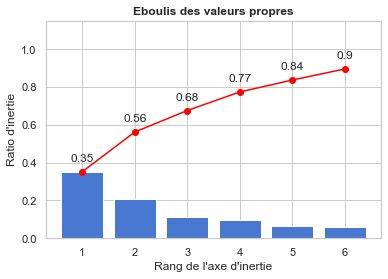

In [48]:
res_pca = pca_modelisation(X_scaled, ind_names=ind_names, scree_plot=True)

Les axes de rang supérieur à 2 apportent relativement peu d'information supplémentaire.

In [49]:
X_projected = res_pca['X_projected']
X_projected_df = res_pca['X_projected_df']
pca = res_pca['pca']

On représente les projections des pays sur les deux premiers axes principaux d'inertie F1 et F2 afin de détecter d'éventuels outliers.

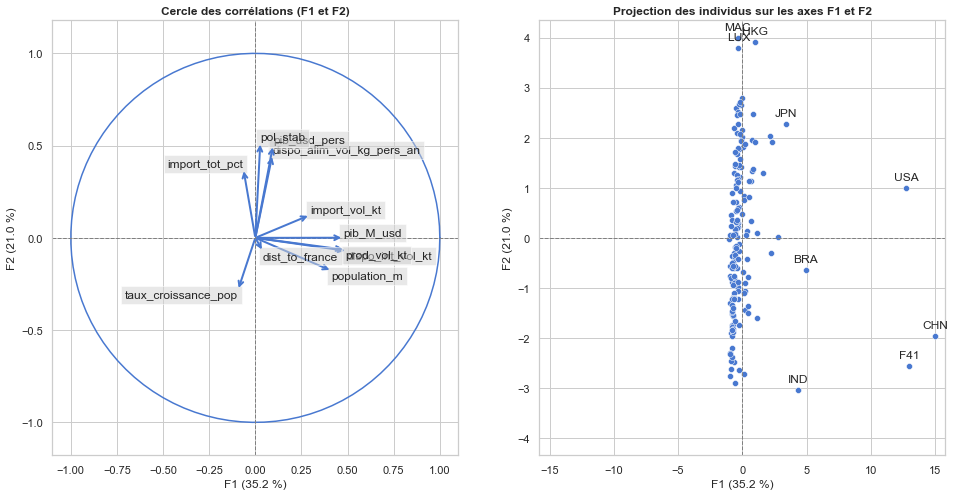

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

draw_corr_circle(pca, components=(0, 1), features=features, ax=axes[0])
repr_ind_projected(X_projected, pca, components=(0, 1), ax=axes[1])

outliers = X_projected_df.loc[(X_projected_df['F1'] > 3) | (X_projected_df['F2'] > 3)]

# on annote les outliers
for country, xy in outliers[['F1', 'F2']].iterrows():
    axes[1].annotate(
        text=country,
        xy=xy,
        xytext=(0, 8), textcoords='offset points',
        ha='center'
    )

L'axe principal d'inertie **F1** est corrélé positivement à la production `prod_vol_kt` et à la disponibilité intérieure en viande de volailles `dispo_int_vol_kt`, au PIB `pib_M_usd`, à la taille de la population `population_m`, ainsi qu'aux importations en viande de volailles `import_vol_kt`. Cet axe reflète la **taille du marché**.

L'axe **F2** est quant à lui corrélé positivement à la stabilité politique `pol_stab`, au PIB par habitant `pib_usd_hab`, à la disponibilité alimentaire en viande de volailles par habitant `dispo_alim_vol_kg_pers_an` ainsi qu'à la part des importations dans les disponibilités pour tous les produits `import_tot_pct`. Il est corrélé négativement au taux de croissance de la population `taux_croissance_pop`. Cet axe est en lien avec le **développement économique** du pays.

La distance à la France n'est quant à elle pas très bien représentée sur le plan.

A noter que l'on observe la présence d'outliers.

On définit les outliers comme les individus ayant des valeurs supérieures à trois écart-types pour l'une des deux premières composantes principales.

In [51]:
outliers = X_scaled_df.loc[(X_projected_df['F1'] > 3) | (X_projected_df['F2'] > 3)]

In [52]:
outliers

,dispo_alim_vol_kg_pers_an,dispo_int_vol_kt,population_m,pib_M_usd,pib_usd_pers,prod_vol_kt,import_vol_kt,import_tot_pct,taux_croissance_pop,pol_stab,dist_to_france
BRA,1.720542,3.514666,0.869846,0.766534,-0.195538,4.798792,-0.426778,-1.105985,-0.388204,-0.387439,0.656649
CHN,-0.381663,7.412560,7.635926,6.042055,-0.253235,6.565012,6.885795,-0.729578,-0.579623,-0.128162,0.510551
F41,-0.412357,7.012381,7.461691,5.847819,-0.257442,6.319206,1.705265,-0.769609,-0.575596,-0.128162,0.510551
HKG,1.597767,-0.208151,-0.232899,-0.087509,1.704493,-0.276667,3.865798,3.139411,-0.586329,1.004091,0.960928
IND,-1.079475,1.223643,7.154084,1.044631,-0.617504,1.079755,-0.441023,-1.047807,-0.067456,-0.698060,0.340119
JPN,-0.104794,0.633764,0.420931,2.188386,1.343719,0.509555,4.635042,0.804267,-1.166683,1.305900,0.982102
LUX,-0.113563,-0.291265,-0.270555,-0.224139,5.122591,-0.285279,-0.388790,1.387036,0.628604,1.534214,-1.431886
MAC,0.864877,-0.287417,-0.270323,-0.231704,3.468794,-0.283844,-0.331809,3.245674,0.606926,1.646022,0.955580
USA,2.231060,6.748032,1.535115,9.402857,2.411391,7.578382,0.143033,-0.813014,-0.413941,0.430048,0.418711


On s'intéresse au profil des outliers.

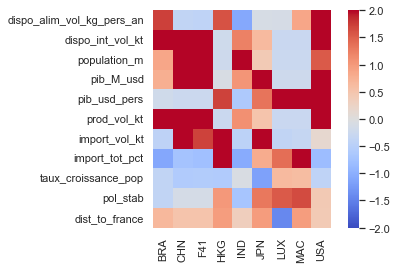

In [53]:
sns.heatmap(outliers.T, vmin=-2, vmax=2, center=0, cmap='coolwarm', square=True)
plt.show()

Les pays qui importent le plus de viande de volailles, et qui sont donc potentiellement intéressants, sont **la Chine, Hong-Kong et le Japon**.<br>
La Chine présente une disponibilité alimentaire par habitant relativement faible, mais celle-ci est compensée par la taille très importante de sa population.<br>
A l'inverse, Hong-Kong présente une disponibilité alimentaire élevée mais une taille de la population modeste.<br>
Le Japon a un profil intermédiaire avec une disponibilité alimentaire et une taille de population moyennes. De plus, contrairement à la Chine et Hong Kong, il possède une bonne stabilité politique.

On refait l'ACP sans ces outliers.

In [54]:
data_wo_outliers = data_cleaned.loc[~(data_cleaned['code_zone_iso3'].isin(outliers.index))]

In [55]:
data_preprocessed = preprocessing(data_wo_outliers, ind_names='code_zone_iso3')

Colonnes utilisées :
['dispo_alim_vol_kg_pers_an', 'dispo_int_vol_kt', 'population_m', 'pib_M_usd', 'pib_usd_pers', 'prod_vol_kt', 'import_vol_kt', 'import_tot_pct', 'taux_croissance_pop', 'pol_stab', 'dist_to_france']

Colonnes ignorées car non numériques :
['code_zone_iso3', 'zone']


In [56]:
X_scaled = data_preprocessed['X_scaled']
X_scaled_df = data_preprocessed['X_scaled_df']
features = data_preprocessed['features']
ind_names = data_preprocessed['ind_names']

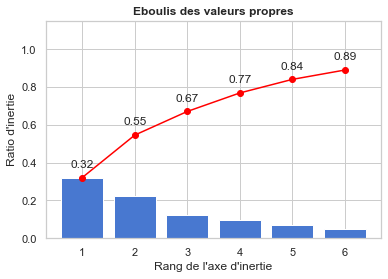

In [57]:
res_pca = pca_modelisation(X_scaled, ind_names=ind_names, scree_plot=True)

In [58]:
X_projected = res_pca['X_projected']
pca = res_pca['pca']

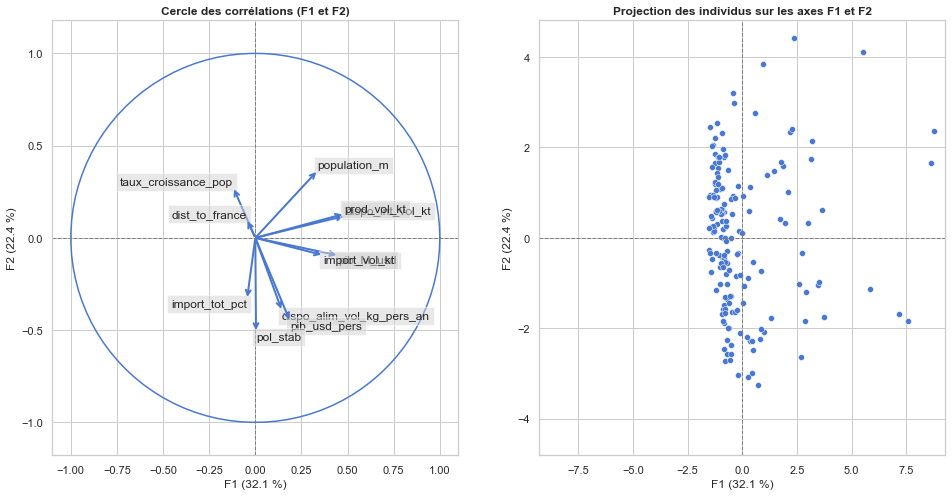

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

draw_corr_circle(pca, components=(0, 1), features=features, ax=axes[0])
repr_ind_projected(X_projected, pca, components=(0, 1), ax=axes[1])

Les axes représentant les composantes principales sont similaires aux précédents, mis à part le fait que l'axe F2 est inversé (il est désormais négativement corrélé aux variables telles que la stabilitié politique, le PIB par habitant, etc.).

## Clustering

Nous allons utiliser deux méthodes de partionnement (clustering) différentes : la classification hiérarchique ascendante et la méthode des K-moyennes (K-means en anglais).

### Méthode de la classification hiérarchique ascendante (CAH)

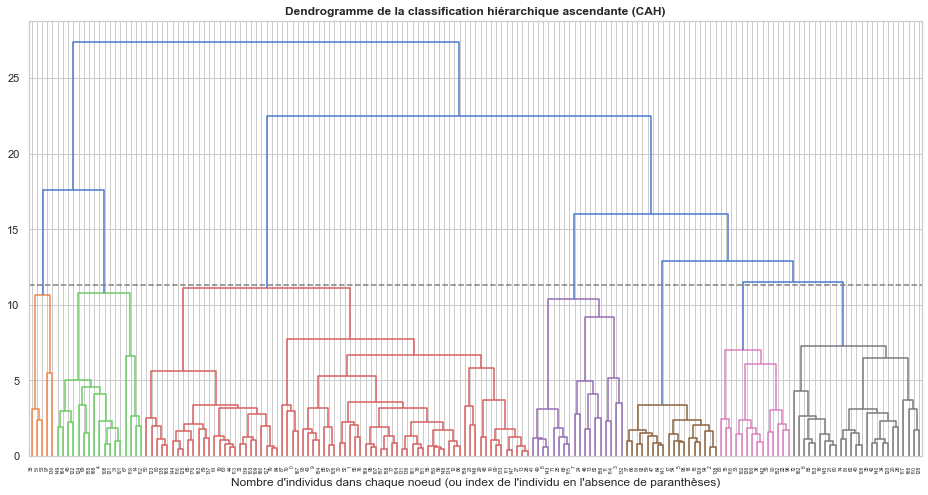

In [60]:
ahc = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ahc.fit(X_scaled)

fig, ax = plt.subplots(figsize=(16, 8))

threshold = 11.3

plot_dendrogram(ahc, color_threshold=threshold, ax=ax)

ax.axhline(y=threshold, color='grey', linestyle='--')

ax.set_title("Dendrogramme de la classification hiérarchique ascendante (CAH)")
ax.set_xlabel(
    "Nombre d'individus dans chaque noeud (ou index de l'individu "
    "en l'absence de paranthèses)"
)

plt.show()

Pour nous aider dans le choix du nombre de clusters, on peut calculer l'indice de Davies-Bouldin et le coefficient de silhouette, deux mesures de la qualité d'un clustering.<br>
**L'indice de Davies-Bouldin** d'un cluster correspond au rapport entre l'homogénéité de ce cluster (distance intracluster) et la séparation entre ce cluster et le cluster qui lui est le plus similaire (distance intercluster). On peut évaluer la qualité d'un clustering en calculant un indice de Davies-Bouldin global qui correspond à la moyenne des indices des différents clusters. **On veut que cet indice soit minimal** (faible distance intracluster et distance intercluster élevée).<br>
**Le coefficient de silhouette** d'un individu correspond à la différence entre la distance moyenne entre cet individu et les autres individus du même cluster (homogénéité) ; et la valeur minimale des distances moyennes entre cet individu et les individus de chacun des autres clusters (séparation). Une valeur négative de ce coefficient signifie que l'individu est en moyenne plus proche d'un autre cluster que le sien, et donc qu'il est mal classé. Le coefficient de silhouette pour un clustering correspond à la moyenne des coefficients des individus. **On veut que cette valeur soit maximale**.

---
Sources :
- https://openclassrooms.com/fr/courses/4379436-explorez-vos-donnees-avec-des-algorithmes-non-supervises/4379556-definissez-les-criteres-que-doit-satisfaire-votre-clustering
- https://fr.wikipedia.org/wiki/Indice_de_Davies-Bouldin
- https://fr.wikipedia.org/wiki/Silhouette_(clustering)

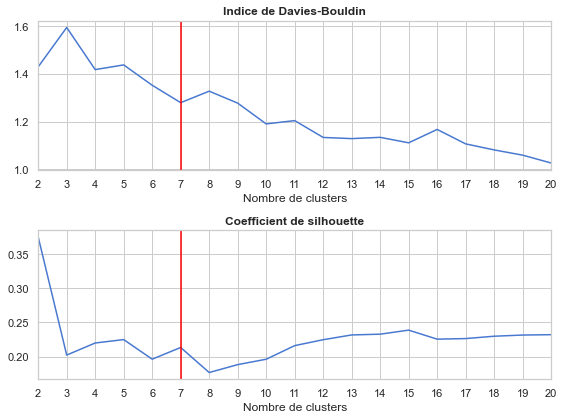

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

plot_davies_bouldin_scores(X_scaled, method='ahc', ax=ax1)
plot_silhouette_scores(X_scaled, method='ahc', ax=ax2)

for ax in (ax1, ax2):
    ax.axvline(x=7, color='red')

fig.tight_layout()

Avec 7 clusters on obtient un indice de Davies-Bouldin relativement faible et un coefficient de silhouette élevé.

,count
cluster,
0,74
1,17
2,25
3,5
4,18
5,18
6,14


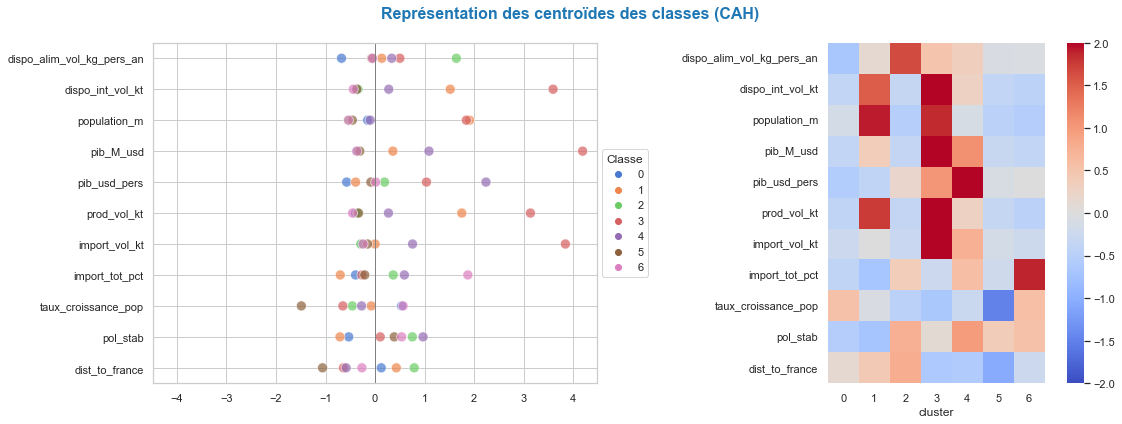

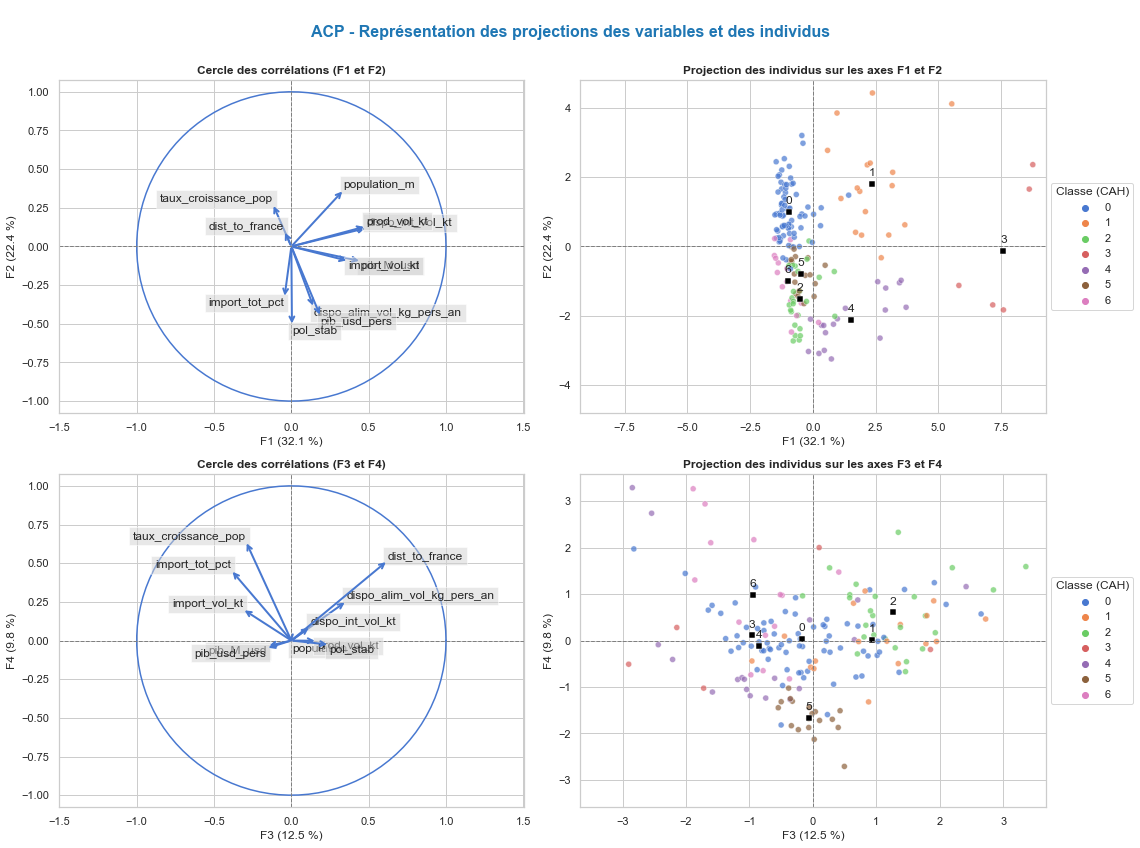

In [62]:
clustering_and_pca(X_scaled, n_clusters=7, method='ahc', features=features)

Les **clusters 3 et 4** semblent être les plus intéressants.<br>
Les projections des centroïdes de ces clusters ont des valeurs positives pour F1 (corrélée à la taille du marché) et négatives pour F2 (anticorrélée au développement économique).<br>
En s'intéressant aux variables initiales à travers la carte de chaleur, on observe que ces deux centroïdes présentent des importations de viande de volailles élevées. Les pays du cluster 3 représentent un marché plus important (disponbilité intérieure, population). En revanche, les pays du cluster 4 présentent un niveau de vie plus élevé (PIB par habitant), ainsi qu'une meilleure stabilité politique.

On peut également représenter les clusters sous forme de boxplot pour visualiser la dispersion des valeurs de leurs individus.

In [63]:
clusters_ahc_7 = get_ahc_clusters(X_scaled, n_clusters=7)

In [64]:
# on ajoute les clusters dans un dataframe contenant les données scalées
clustering_df = X_scaled_df.copy()
clustering_df['cluster_ahc_7'] = clusters_ahc_7

In [65]:
ahc_3_4 = clustering_df.loc[clustering_df['cluster_ahc_7'].isin([3, 4])]

ahc_melted = pd.melt(
    ahc_3_4,
    id_vars='cluster_ahc_7'
)
ahc_melted.head(3)

,cluster_ahc_7,variable,value
0,4,dispo_alim_vol_kg_pers_an,0.392223
1,4,dispo_alim_vol_kg_pers_an,1.954633
2,4,dispo_alim_vol_kg_pers_an,-0.100069


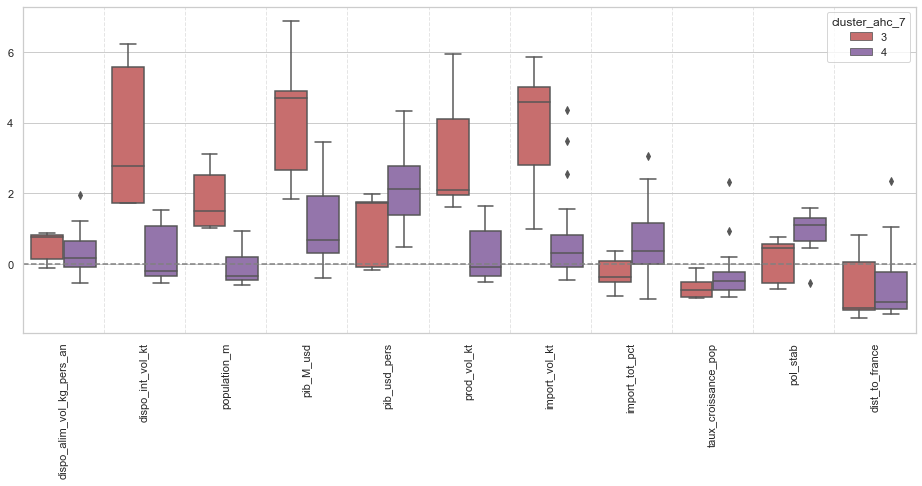

In [66]:
# on utilise une palette pour conserver les mêmes couleurs que dans les graphiques précédents
palette = {i: color for i, color in enumerate(sns.color_palette(n_colors=7))}

fig, ax = plt.subplots(figsize=(16, 6))

sns.boxplot(
    data=ahc_melted,
    x='variable',
    y='value',
    hue='cluster_ahc_7',
    palette=palette,
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.set_ylabel('')

# on utilise la grille pour créer des séparations entre les variables
minor_ticks = np.arange(ahc_melted['variable'].nunique() - 1) + 0.5
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', linestyle='--', alpha=0.5)

ax.axhline(color='grey', linestyle='--')

plt.show()

Le <b><span style="color:#d65f5f">cluster 3</span></b> montre une certaine variabilité, ce qui n'est pas suprenant étant donné la dispersion des points sur le plan formé par les deux premières composantes principales de l'ACP. On observe également la présence d'outliers dans le <b><span style="color:#956cb4">cluster 4</span></b> pour certaines variables (disponibilités alimentaires, importations, taux de croissance et distance à la France).

On affiche le nom des pays qui composent les clusters 3 et 4.

In [67]:
# on récupère les noms complets des pays
countries_ahc_3_4 = ahc_3_4[['cluster_ahc_7']] \
    .merge(iso3, left_index=True, right_on='iso3') \
    .set_index('iso3') \
    .rename(columns={'name': 'country'})

# on affiche ces noms
for i in (3, 4):
    if i == 4: print()
    countries = countries_ahc_3_4 \
        .loc[countries_ahc_3_4['cluster_ahc_7'] == i,
             'country'] \
        .tolist()
    print(f"Cluster {i} :\n{countries}")

Cluster 3 :
['Germany', 'France', 'United Kingdom', 'Mexico', 'Russian Federation']

Cluster 4 :
['United Arab Emirates', 'Australia', 'Austria', 'Belgium', 'Canada', 'Switzerland', 'Denmark', 'Spain', 'Finland', 'Ireland', 'Iceland', 'Italy', 'Republic of Korea', 'Netherlands', 'Norway', 'Saudi Arabia', 'Sweden', 'China, Taiwan Province of']


On représente les pays sur la carte du Monde.

In [68]:
color_discrete_map = {
    str(i): 'rgb' + str(color)
    for i, color in enumerate(sns.color_palette(n_colors=9))
}

fig = px.choropleth(
    countries_ahc_3_4,
    locations=countries_ahc_3_4.index,
    hover_name='country',
    color=countries_ahc_3_4['cluster_ahc_7'].astype(str),
    color_discrete_map=color_discrete_map,
    title='Classification hiérarchique ascendante : clusters 3 et 4'
)

fig.update_layout(title_x=0.5)
fig.show()

https://plotly.com/python-api-reference/generated/plotly.express.choropleth.html

### Méthode des K-means

On réalise la même démarche que ci-dessus avec la méthode des K-moyennes (ou K-means en anglais).

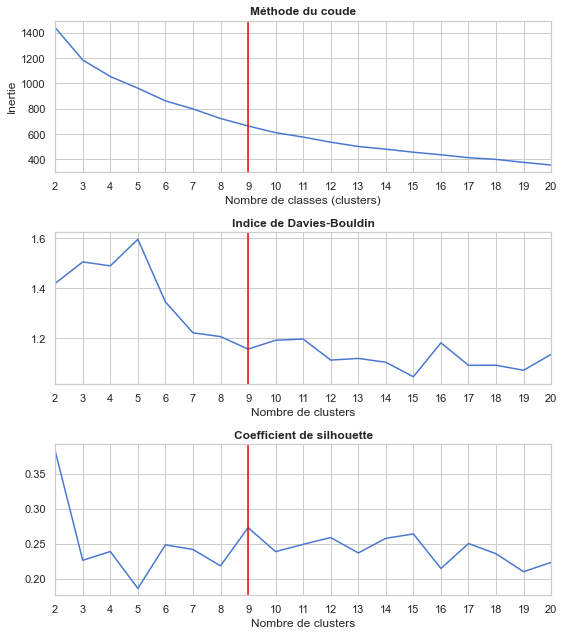

In [69]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9))

plot_elbow(X_scaled, 20, ax=axes[0])
plot_davies_bouldin_scores(X_scaled, method='kmeans', ax=axes[1])
plot_silhouette_scores(X_scaled, method='kmeans', ax=axes[2])

for ax in axes:
    ax.axvline(x=9, color='red')

fig.tight_layout()

La méthode du coude nous permet difficilement de trouver le nombre optimal de cluster. En se basant sur l'indice de Davies-Bouldin et le cofficient de silhouette, un nombre de 9 clusters nous apparait satisfaisant.

,count
cluster,
0,62
1,26
2,2
3,10
4,29
5,14
6,14
7,4
8,10


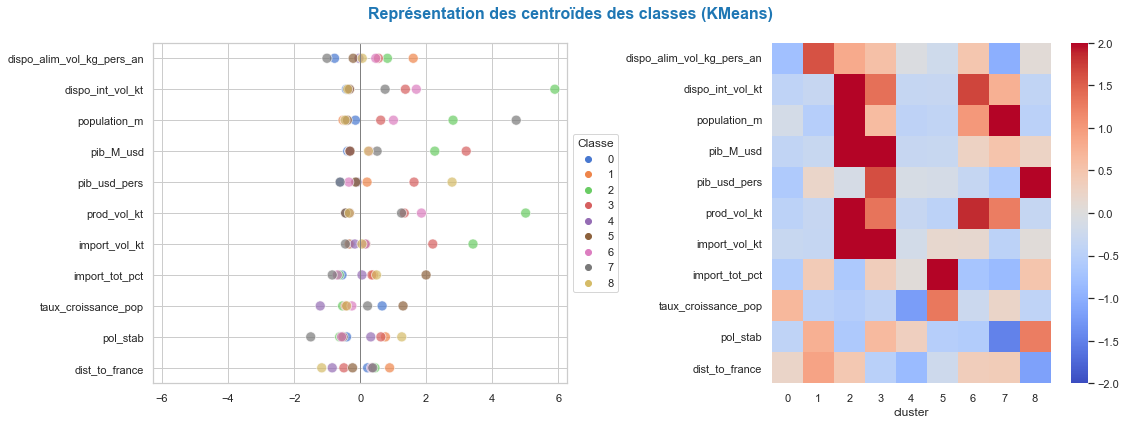

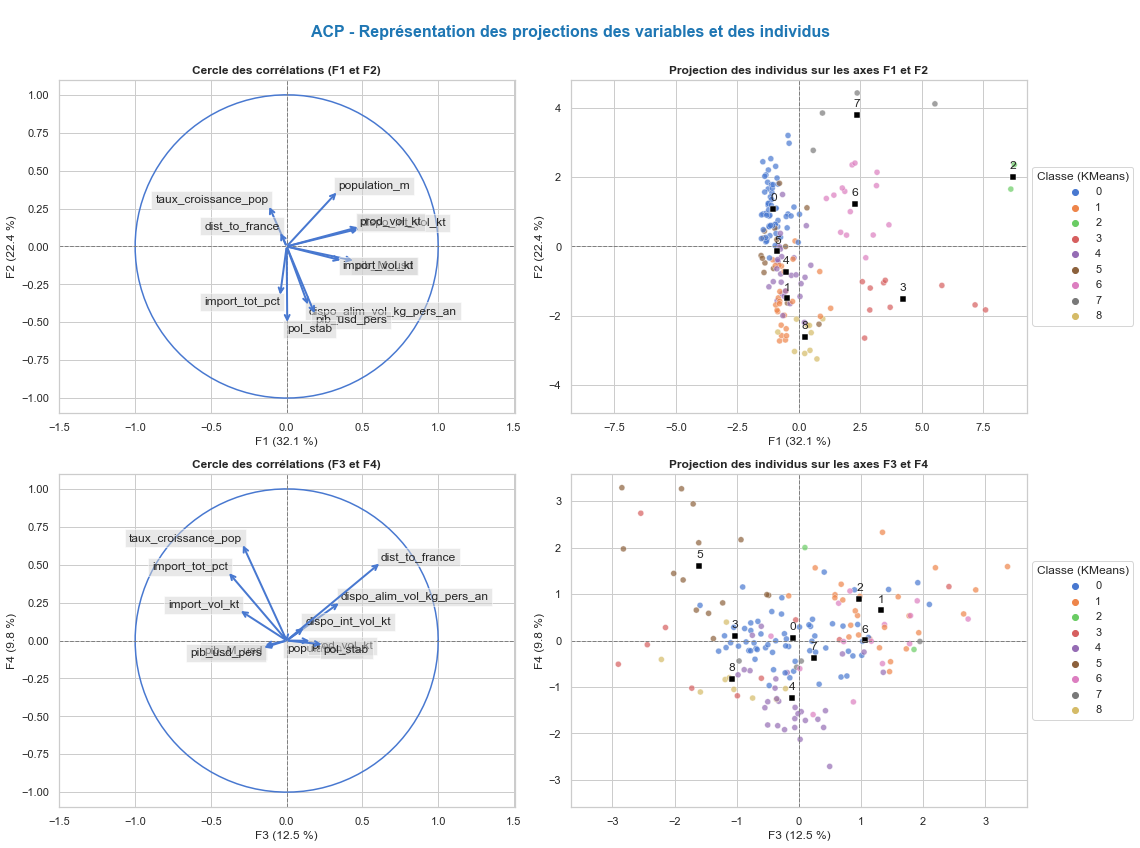

In [70]:
centroid_df = clustering_and_pca(X_scaled, 9, method='kmeans', features=features)

Les **clusters 2 et 3** semblent être les plus intéressants. En effet, ils présentent tous les deux des importations de viande de volailles élevées. Les pays du cluster 2 représentent un marché plus important (disponbilité intérieure, population). En revanche, les pays du cluster 3 présentent un niveau de vie plus élevé (PIB par habitant), ainsi qu'une meilleure stabilité politique.

In [71]:
# on récupère les clusters
clusters_kmeans_9 = get_kmeans_clusters(X_scaled, 9)
clustering_df['cluster_kmeans_9'] = clusters_kmeans_9

On affiche le nom des pays qui composent les clusters 2 et 3.

In [72]:
kmeans_2_3 = clustering_df.loc[clustering_df['cluster_kmeans_9'].isin([2, 3])] \
    .drop(columns='cluster_ahc_7')

# on récupère les noms complets des pays
countries_kmeans_3_4 = kmeans_2_3[['cluster_kmeans_9']] \
    .merge(iso3, left_index=True, right_on='iso3') \
    .set_index('iso3') \
    .rename(columns={'name': 'country'})

# on affiche ces noms
for i in (2, 3):
    if i == 3: print()
    countries = countries_kmeans_3_4 \
        .loc[countries_kmeans_3_4['cluster_kmeans_9'] == i,
             'country'] \
        .tolist()
    print(f"Cluster {i} :\n{countries}")

Cluster 2 :
['Mexico', 'Russian Federation']

Cluster 3 :
['Australia', 'Canada', 'Germany', 'Spain', 'France', 'United Kingdom', 'Italy', 'Republic of Korea', 'Netherlands', 'Saudi Arabia']


Il semblerait qu'une partie des pays soit identiques entre les clusters issus de la CAH et des K-means que l'on a sélectionnés. On cherche à comparer ces clusters.

### Comparaison CAH et KMeans

#### Composition des clusters

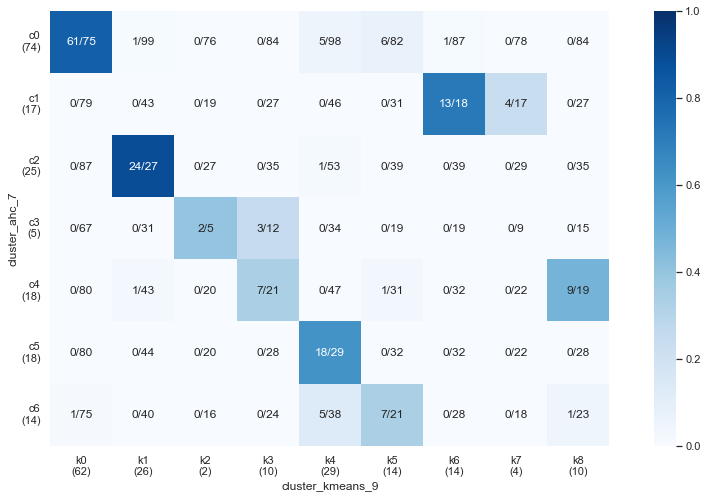

In [73]:
compare_clusterings(
    data=clustering_df,
    clusterings=('cluster_ahc_7', 'cluster_kmeans_9'),
    prefixes=('c', 'k'),
    names_in_index=True
)

Pour rappel, les clusters sélectionnés précédemment correspondent aux clusters c3 et c4 pour la CAH, et k2 et k3 pour les K-means.

Comme on peut le voir dans la carte de chaleur, la totalité des pays sélectionnés avec la méthode des K-means ont également été sélectionnés avec la CAH. En effet, les deux pays qui composent le cluster k2 sont présents dans le cluster c3, et les dix pays du cluster k3 sont répartis entre les clusters c3 et c4.

En revanche, une partie de la sélection issue de la CAH n'est pas présente dans celle issue des K-means. En effet, la moitié des pays du cluster c4 sont dans le cluster k8. Le cluster k8 n'avait pas été retenu car son centroïde présente des importations moyennes et une faible taille de marché.

#### Valeurs des centroïdes

On compare les valeurs des centroïdes des clusters des deux méthodes à l'aide d'un boxplot.

In [74]:
kmeans_melted = pd.melt(
    kmeans_2_3,
    id_vars='cluster_kmeans_9'
)

# on concatène les dataframes des deux méthodes
kmeans_melted['cluster'] = kmeans_melted['cluster_kmeans_9'].apply(lambda x: 'k' + str(x))
ahc_melted['cluster'] = ahc_melted['cluster_ahc_7'].apply(lambda x: 'c' + str(x))

cols = ['cluster', 'variable', 'value']

kmeans_ahc_melted = pd.concat(
    (kmeans_melted[cols], ahc_melted[cols]),
    ignore_index=True
)

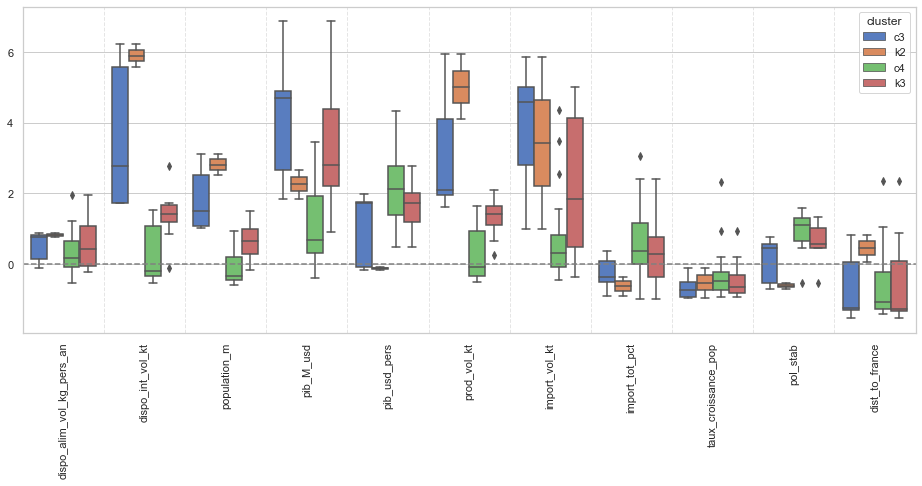

In [75]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.boxplot(data=kmeans_ahc_melted, x='variable', y='value', hue='cluster', hue_order=['c3','k2', 'c4', 'k3'], ax=ax)

ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.set_ylabel('')

# on utilise la grille pour créer des séparations entre les variables
minor_ticks = np.arange(kmeans_ahc_melted['variable'].nunique() - 1) + 0.5
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', linestyle='--', alpha=0.5)

ax.axhline(color='grey', linestyle='--')

plt.show()

#### Carte du Monde

In [76]:
for df, col, title in zip(
    (countries_ahc_3_4, countries_kmeans_3_4),
    ('cluster_ahc_7', 'cluster_kmeans_9'),
    (
        'Classification hiérarchique ascendante : clusters 3 et 4',
        'K-moyennes : clusters 2 et 3'
    )
):
    fig = px.choropleth(
        df,
        locations=df.index,
        hover_name='country',
        color=df[col].astype(str),
        color_discrete_map=color_discrete_map,
        title=title
    )

    fig.update_layout(title_x=0.5)
    fig.show()

#### Conclusion

Les deux méthodes de clustering nous ont permis d'identifier des pays potentiellement intéressants, présentant notamment des importations en viande de volailles et une taille de marché importantes. Bien que le nombre de pays retenus soit différent selon la méthode utilisée, la totalité des pays identifiés avec les K-means ont également été identifiés avec la CAH. A noter que les différents clusters présentent encore une certaine variabilité (variance intracluster). Il faut donc garder en tête que cette analyse reste préliminaire et qu'il est nécessaire d'étudier ces pays individuellement, avec des connaissances métier (permettant notamment de déterminer quelles variables sont rédhibitoires), afin d'identifier ceux qui sont réellement intéressants.